# EOF Analysis of AR days

* Multivariate EOF analysis - testing different configurations to see which cEOF captures the most varaince of precipitation related to AR events

  1. cEOF 250 hPa H, U, V in extratropics, 850 hPa Q, U, V in tropics
  2. cEOF 500 hPa H, U, V in extratropics, 500 hPa Q, U, V in tropics
  3. cEOF 500 hPa H, U, V in extratropics, 500 hPa H, U, V in tropics
  4. cEOF 500 hPa H, U, V in full domain [0-120 E, 0-50N]
  5. cEOF IVTu and IVTv in full domain
  6. cEOF 500 hPa H, U, V and 850 hPa Q in full domain?


In [1]:
# Import Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from itertools import cycle
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *
import nclcmaps as ncl

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/test/k3/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### AR time series

In [4]:
## Select MERRA2 or ERA5
reanalysis = 'era5'

if reanalysis == 'era5':
    start_date = '1979-01-01'
    end_date = '2018-12-31'
    filename = 'ar_catalog_ERAI_fraction_HASIAsubregions.nc'
## if MERRA2
else:
    start_date = '1980-01-01'
    end_date = '2017-12-31'
    filename = 'ar_catalog_fraction_HASIAsubregions.nc'
    
f1 = path_to_data + 'CH1_generated_data/' + filename
ds = xr.open_dataset(f1)
# Set dates
ds = ds.sel(time=slice(start_date, end_date))
## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()

,R01,R02,R03,ar,location
time,,,,,
1979-01-01,0.000000,0.0,0.0,0,NaN
1979-01-02,0.000000,0.0,0.0,0,NaN
1979-01-03,0.005102,0.0,0.0,0,NaN
1979-01-04,0.000000,0.0,0.0,0,NaN
1979-01-05,0.000000,0.0,0.0,0,NaN


### Configuration Dictionary

In [5]:
# import configuration file for season dictionary choice
yaml_doc = '../data/config.yml'
config1 = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
ssn = 'djfmam'
ar_dict = config1[ssn]

# import configuration file for ceof dictionary choice
## test number - NOTE as of 7/1/2020 sticking with test 4
yaml_doc = '../data/ceof_config.yml'
config2 = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
config_dict = config2['test4']


### Import reanalysis

#### ERA5

In [6]:
## Set variable names (for saving data/figs)
testname = config_dict['name']
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance
pathvar = config_dict['pathvar']

# Select lat/lon grid 
# Tropics/Extratropics Domain
lonmin = config_dict['latlon'][0]
lonmax = config_dict['latlon'][1]
latmin = config_dict['latlon'][2]
latmax = config_dict['latlon'][3]

lev = config_dict['levs']

# for figure names for testing different configurations
fname_id = config_dict['fnameID'] + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat
print(fname_id)

if pathvar == 'huvq':
    def preprocess(ds):
        '''keep only selected lats and lons'''
        return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=lev)
if pathvar == 'ivt':
        def preprocess(ds):
            '''keep only selected lats and lons'''
            return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open anomaly data
filepath_pattern = path_to_data + 'ERA5/{0}/anomalies/daily_filtered_anomalies_{0}_*.nc'.format(pathvar)
    
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')

f2

HUV500t0120050cor


<xarray.Dataset>
Dimensions:    (latitude: 101, level: 1, longitude: 241, time: 14610)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 118.5 119.0 119.5 120.0
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 48.0 ... 1.5 1.0 0.5 0.0
  * level      (level) float64 500.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    z          (time, level, latitude, longitude) float64 dask.array<chunksize=(365, 1, 101, 241), meta=np.ndarray>
    q          (time, level, latitude, longitude) float64 dask.array<chunksize=(365, 1, 101, 241), meta=np.ndarray>
    u          (time, level, latitude, longitude) float64 dask.array<chunksize=(365, 1, 101, 241), meta=np.ndarray>
    v          (time, level, latitude, longitude) float64 dask.array<chunksize=(365, 1, 101, 241), meta=np.ndarray>

In [7]:
if pathvar == 'huvq':

    # Create new dataset to rename lat lon
    ds = xr.Dataset({'H': (['time', 'level', 'lat', 'lon'], f2['z'].values),
                     'U': (['time', 'level',  'lat', 'lon'], f2['u'].values),
                     'V': (['time', 'level',  'lat', 'lon'], f2['v'].values),
                     'QV': (['time', 'level',  'lat', 'lon'], f2['q'].values)},
                          coords={'time': (['time'], f2.time.values),
                                  'level': (['level'], f2.level.values),
                                  'lat': (['lat'], f2.latitude.values),
                                  'lon': (['lon'], f2.longitude.values)})

if pathvar == 'ivt':
    ds = xr.Dataset({'ivte': (['time', 'lat', 'lon'], f2['p71.162'].values),
                     'ivtn': (['time', 'lat', 'lon'], f2['p72.162'].values)},
                          coords={'time': (['time'], f2.time.values),
                                  'lat': (['lat'], f2.latitude.values),
                                  'lon': (['lon'], f2.longitude.values)})


ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 11.38



In [8]:
# Add AR time series to merra; set as coordinate variables
ds['ar'] = ('time', df.ar)
ds = ds.set_coords('ar')

ds['location'] = ('time', df.location)
ds = ds.set_coords('location')

# print dataset
print(ds)

<xarray.Dataset>
Dimensions:   (lat: 101, level: 1, lon: 241, time: 14610)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * level     (level) float64 500.0
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location  (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    H         (time, level, lat, lon) float64 -2.615e+03 -2.655e+03 ... 222.9
    U         (time, level, lat, lon) float64 1.489 1.765 1.789 ... 5.374 5.342
    V         (time, level, lat, lon) float64 -9.859 -9.301 ... -1.137 -1.631
    QV        (time, level, lat, lon) float64 -0.0004586 -0.000463 ... 0.0003623


### Data Subset Selection

In [9]:
idx = slice(ar_dict['start_date'], ar_dict['end_date'])
ds = ds.sel(time=idx)

# Select months
if ar_dict['mon_s'] > ar_dict['mon_e']:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
else:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])

ds = ds.sel(time=idx)

# # Select AR days JUST IN R01
# idx = (ds.ar >= 1) & (ds.location == 'R01')
# Select AR days in all subregions
idx = (ds.ar >= 1)
ds_ar = ds.sel(time=idx)
# ds_ar = ds

# print results
print(ds_ar)

<xarray.Dataset>
Dimensions:   (lat: 101, level: 1, lon: 241, time: 812)
Coordinates:
  * time      (time) datetime64[ns] 1979-03-08T09:00:00 ... 2018-05-14T09:00:00
  * level     (level) float64 500.0
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'R03' 'R03' 'R03' 'R01' ... 'R03' 'R03' 'R01' 'R01'
Data variables:
    H         (time, level, lat, lon) float64 -234.0 -249.7 ... 69.62 65.11
    U         (time, level, lat, lon) float64 6.974 7.249 ... -2.562 -3.025
    V         (time, level, lat, lon) float64 -2.551 -2.901 ... -0.975 -1.057
    QV        (time, level, lat, lon) float64 -0.0001318 ... -0.001152


In [10]:
# Count number of independent AR events

years = np.arange(ar_dict['ys'], ar_dict['ye']) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single season
    date1 = "{0}-{1}-{2}".format(years[k], ar_dict['mon_s'], ar_dict['day_s'])
    date2 = "{0}-{1}-{2}".format(years[k+1], ar_dict['mon_e'], ar_dict['day_e'])
    x = ds.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  438


## Preprocessing

### Reshape, center, and standardize data matrix

In [11]:
%%time
# Load merra_ar dataset into memory
ds_ar = ds_ar.load()


CPU times: user 17 µs, sys: 90 µs, total: 107 µs
Wall time: 118 µs


In [12]:
## Create list of variable arrays
    
var_list = []
for i in range(len(config_dict['varlist'])):
    var1 = config_dict['varlist'][i]
    domain = config_dict['domain'][i]
    domain_bnds = config2['eof_domain'][domain]
    lonslice = slice(domain_bnds[0], domain_bnds[1])
    latslice = slice(domain_bnds[3], domain_bnds[2])
    if pathvar == 'huvq':
        lev = config_dict['varlev'][i]
        var_list.append(ds_ar[var1].sel(lon=lonslice, lat=latslice, level=lev))
    if pathvar == 'ivt':
        var_list.append(ds_ar[var1].sel(lon=lonslice, lat=latslice))

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)


(812, 101, 241)
(812, 101, 241)
(812, 101, 241)


In [13]:
%%time
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Flatten data to [time x space]
var_list = flatten_array(var_list)

## Center data
var_list = center_data(var_list)

## Standardize Arrays by removing the mean and dividing by the standard deviation of the columns
## For multivariate, place into single flattened array
Xs = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)


EOF mode:  t
Dispersion Matrix:  cor
(73023, 812)
Column means:  0.0
Column std:  1.0
CPU times: user 3.98 s, sys: 2.09 s, total: 6.07 s
Wall time: 6.05 s


## EOF Analysis

In [14]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eigs(z=Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (812,)
[1.06633517e+02 7.80681907e+01 6.12793277e+01 5.20216549e+01
 3.76098668e+01 3.59069558e+01 3.32152850e+01 3.02649815e+01
 2.66681005e+01 2.41369869e+01 2.23707777e+01 1.77700253e+01
 1.59158562e+01 1.40360641e+01 1.35518431e+01 1.22035342e+01
 1.06303290e+01 9.71031896e+00 8.95229056e+00 8.49022970e+00
 8.17450450e+00 7.53086378e+00 6.88057398e+00 6.22194492e+00
 5.89981769e+00 5.30683927e+00 5.21219094e+00 4.62615546e+00
 4.27421304e+00 3.99740396e+00 3.83593371e+00 3.70240539e+00
 3.57927654e+00 3.19774033e+00 3.12922487e+00 3.03071388e+00
 2.85468995e+00 2.67045311e+00 2.60863086e+00 2.36829671e+00
 2.29495412e+00 2.16966994e+00 2.12588419e+00 2.04129564e+00
 1.91576898e+00 1.89600061e+00 1.80747340e+00 1.73180971e+00
 1.69751450e+00 1.63084668e+00 1.59565977e+00 1.55818360e+00
 1.46666581e+00 1.43060029e+00 1.40839372e+00 1.34322094e+00
 1.27285154e+00 1.22837875e+00 1.20598481e+00 1.16237678e+00
 1.12369243e+00 1.08855321e+00 1.08011461e+00 1.05115812e+00
 1.

### Explained Variance

In [15]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 21 EOFs:
76.28% 

Cumulative variance explained by the first 4 EOFs:
30.29% 

1 	 13.13%
2 	 9.61%
3 	 7.55%
4 	 6.41%


### North Test

In [16]:
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[14.019 10.264  8.057  6.839  4.945  4.721]
[13.132  9.614  7.547  6.407  4.632  4.422]
[12.245  8.965  7.037  5.974  4.319  4.123]


### Variance Plot

/home/nash/DATA/repositories/AR_types/figs/test/k3/test4djfmam_exp_variance.png


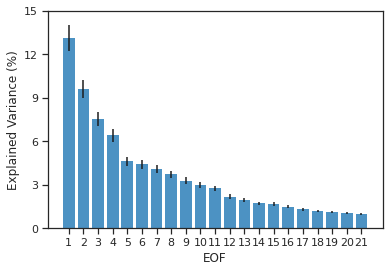

In [17]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,16,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs  + testname + ssn + '_exp_variance' + '.png'
print(filepath)
plt.savefig(filepath, dpi=300)

# show
plt.show()

### EOFs and PCs

In [18]:
# choose neofs and npcs based on North Test
# to save, plot, etc.
neofs = 2
npcs = 2

# Calculate EOFS (spatial modes)
eofs = calc_eofs(Xs, evecs, evals, neofs, mode=eofmode)

# Split eofs into separate arrays for each variable
ntim, nlat, nlon = var1.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
eofmodes = var_list
for i in np.arange(len(var_list)):
    tmp = eofs[:,i*npts:(i+1)*npts]
    eofmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))
    
# Calculate PCs (time coefficients)
pcs = calc_pcs(Xs, evecs, evals, npcs, mode=eofmode)
# results in [ntim, npcs] to plot in PC plot

## loadings*
## in the case of t-mode these are our "pcs" or time-coefficients
## in the case of s-mode, these are our "eofs" or spatial loadings
loads = pcs

### Save Eigenvectors, eigenvalues, and temporal loadings.

In [19]:
# # Save eigenvalues, eigenvectors, and loadings


# outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
# np.savetxt(outfile, evals, fmt='%.5f')

# outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
# np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

# outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
# np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### Spatial Modes

In [20]:
ds_ar

<xarray.Dataset>
Dimensions:   (lat: 101, level: 1, lon: 241, time: 812)
Coordinates:
  * time      (time) datetime64[ns] 1979-03-08T09:00:00 ... 2018-05-14T09:00:00
  * level     (level) float64 500.0
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'R03' 'R03' 'R03' 'R01' ... 'R03' 'R03' 'R01' 'R01'
Data variables:
    H         (time, level, lat, lon) float64 -234.0 -249.7 ... 69.62 65.11
    U         (time, level, lat, lon) float64 6.974 7.249 ... -2.562 -3.025
    V         (time, level, lat, lon) float64 -2.551 -2.901 ... -0.975 -1.057
    QV        (time, level, lat, lon) float64 -0.0001318 ... -0.001152

In [21]:
# Data for plotting 
lons = ds_ar.lon.data
lats = ds_ar.lat.data
udat = eofmodes[1][0:neofs,:,:]
vdat = eofmodes[2][0:neofs,:,:]
data = eofmodes[0][0:neofs,:,:]

print(np.nanmin(data), np.nanmax(data))

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

-31.92845011117092 40.96678351761048


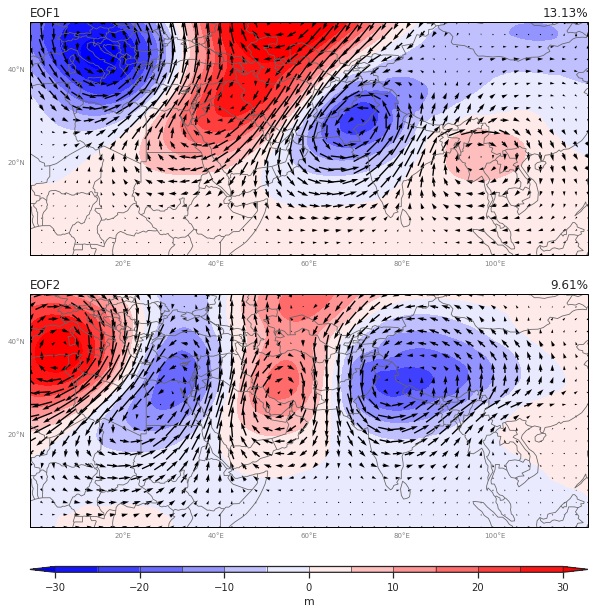

In [22]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + testname + ssn + '_spatial' + '.png'
nrows = neofs
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
    clevs = np.arange(-30,31,5)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # Wind barbs / vectors
    ax.quiver(lons, lats, udat[k,:,:], vdat[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=20) 
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('m', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

### K-means clustering

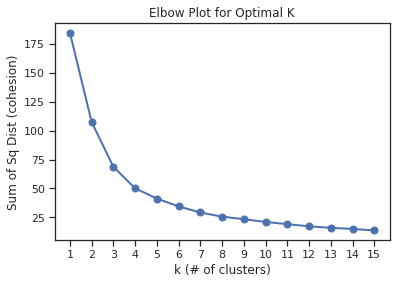

In [23]:
# Determine optimal K

# maximum number of clusters (number of iterations)
kmax =15
# input data
xdata = loads[:,0:neofs]

# Elbow plot
outfile = path_to_figs + testname + ssn + '_elbow'
plot_optimal_k(xdata, kmax, filename=outfile)


In [24]:
## K-means cluster analysis

# Number of clusters
nk = 3

# Input data
xdata = loads[:,0:neofs]

# Compute k means and assign each point to a cluster
kmeans = KMeans(n_clusters=nk)
kmeans.fit(xdata)
cluster = kmeans.predict(xdata)

# LLJ category labels (llj days only)
ar_cat = cluster + 1


In [25]:
# Count number of days in each cluster
klabels, counts = np.unique(ar_cat, return_counts=True)

# Save counts to txt file
res = np.column_stack((klabels,counts))
headstr = 'AR_TYPE, COUNT'
outfile = path_to_out + fname_id + ssn + 'k_counts.txt'
print(outfile)
np.savetxt(outfile, res, delimiter=',', fmt='%d', header=headstr)



/home/nash/DATA/repositories/AR_types/out/HUV500t0120050cordjfmamk_counts.txt


In [26]:
# Cluster centroids (nclust x neofs)
centroids = kmeans.cluster_centers_

# Save centroids to txt file
res = np.column_stack((klabels,centroids))
headstr = "AR_TYPE, EOF1, EOF2, EOF3, EOF4"
outfile = path_to_out + fname_id + ssn + 'centroids.txt'
print(outfile)
np.savetxt(outfile, res, delimiter=',', fmt='%s', header=headstr)


/home/nash/DATA/repositories/AR_types/out/HUV500t0120050cordjfmamcentroids.txt


In [27]:
## Save AR location, loadings (EOF1-2), and category label (AR days only)

# Vector of AR dates
dates_arDays =  ds_ar.time.values

# Create new dataframe
data = {'LOC':ds_ar.location.values,
        'EOF1':loads[:,0],
        'EOF2':loads[:,1],

        'AR_CAT':ar_cat}
df_out = pd.DataFrame(data, index=dates_arDays)

# Export dataframe as csv
outfile = path_to_out + fname_id + ssn + 'hma_AR-types-loadings.csv'
df_out.to_csv(outfile)
print(outfile)

/home/nash/DATA/repositories/AR_types/out/HUV500t0120050cordjfmamhma_AR-types-loadings.csv


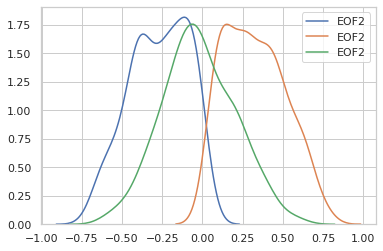

In [28]:
## The right y-axis ticks for the kde
TYPE1 = df_out.loc[df_out.AR_CAT == 1]
TYPE2 = df_out.loc[df_out.AR_CAT == 2]
TYPE3 = df_out.loc[df_out.AR_CAT == 3]

ax = sns.kdeplot(TYPE1.EOF2)
ax = sns.kdeplot(TYPE2.EOF2)
ax = sns.kdeplot(TYPE3.EOF2)


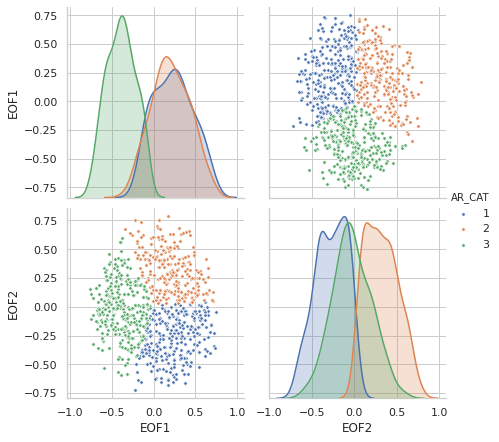

In [29]:
# Pairplot (w/ seaborn)
# diag_kws=dict(shade=True)

# ylims = [(0,2), (-1, 1), (-1, 1), (0,2)]

pp = sns.pairplot(df_out, hue="AR_CAT", height=3, markers='.',
            plot_kws=dict(s=50), diag_kind='kde')

# for ax in pp.axes.flat:
#     # labelleft refers to yticklabels on the left side of each subplot
# #     ax.tick_params(axis='y', labelleft=True) # method 1
# #     yticks = ax.set(ylim=ylims[])
# #     print(yticks)
#     ax.yaxis.set_tick_params(labelleft=True) # method 2

# for i in range(2):
#     for j in range(2):
#         print(i,j)
        
#         if i == j:
#             pp.axes[i][j].set(ylim=(0,2), 
#                              yticks=[0.,0.25,0.5,0.75,1.,1.25, 1.5, 1.75, 2])
#         else:
#             pp.axes[i][j].set(ylim=(-1, 1), 
#                              yticks=[-1., -0.75, -0.5, -0.25 ,0.,0.25,0.5,0.75,1.])
        


plt.show()
filepath = path_to_figs + testname + ssn + '_scatter'+ '.png'
pp.savefig(filepath)

# USE PAIRGRID FOR MORE ADVANCED USE
# g = sns.PairGrid(df_out, hue='AR_CAT', diag_sharey=False)
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot, lw = 3, legend = True)

# g = sns.PairGrid(df_out.dropna(), hue='AR_CAT', diag_sharey=False)
# diag = g.map_diag(sns.kdeplot, shade=False)
# g = g.map_offdiag(plt.scatter)

# # for ax in g.axes.flat:
# #     # labelleft refers to yticklabels on the left side of each subplot
# #     ax.tick_params(axis='y', labelleft=True) # method 1
# # #     ax.yaxis.set_tick_params(labelleft=True) # method 2

# plt.show()

In [30]:
## Save time series of all DJF days with AR types

# Arrays with ALL DJF days
dates_allDays = ds.time.values
ar_cat_allDays = np.zeros(len(dates_allDays), dtype=int)

# Loop over ar days and match to ar_full 
for i, date in enumerate(dates_arDays):
    idx = np.where(dates_allDays == date)
    ar_cat_allDays[idx] = ar_cat[i]

# Create dataframe
data = {'AR_CAT':ar_cat_allDays}
df_out = pd.DataFrame(data, index=dates_allDays)
print(df_out)

outfile = path_to_out + fname_id + 'hma_AR-types-' + ssn + '.csv'
df_out.to_csv(outfile)


                     AR_CAT
1979-03-01 09:00:00       0
1979-03-02 09:00:00       0
1979-03-03 09:00:00       0
1979-03-04 09:00:00       0
1979-03-05 09:00:00       0
...                     ...
2018-05-27 09:00:00       0
2018-05-28 09:00:00       0
2018-05-29 09:00:00       0
2018-05-30 09:00:00       0
2018-05-31 09:00:00       0

[7200 rows x 1 columns]


### Precipitation Composites

### Plot Histogram of Difference in days between Types

In [31]:
## TO DO: Create a loop so that this is cleaner and based on decided number of clusters.
## Separate the AR Types into multiple columns
df_out['AR_CAT1'] = 0
df_out['AR_CAT2'] = 0
df_out['AR_CAT3'] = 0

idx = (df_out['AR_CAT'] == 1) 
df_out.loc[idx, 'AR_CAT1'] = 1

idx = (df_out['AR_CAT'] == 2) 
df_out.loc[idx, 'AR_CAT2'] = 1

idx = (df_out['AR_CAT'] == 3) 
df_out.loc[idx, 'AR_CAT3'] = 1

def nearest(items, pivot):
    '''Find the nearest date in a list compared to a single date'''
    nearest=min(items, key=lambda x: abs(x - pivot))
    timedelta = nearest-pivot
    return timedelta.days

# List of dates that match AR1 conditions
idx = (df_out.AR_CAT1 > 0)
x = df_out.index[idx]

# list of dates that match AR2 conditions
idx = (df_out.AR_CAT2 > 0)
y = df_out.index[idx]

# list of dates that match AR3 conditions
idx = (df_out.AR_CAT3 > 0)
y2 = df_out.index[idx]

ns = [len(x), len(y), len(y2)]
timedel = []
timedel2 = []
timedel3 = []
for i in range(len(x)):
#     t1 = pd.to_datetime(x.iloc[i])
    t1 = x[i]
    t2 = pd.to_datetime(y)
    t3 = pd.to_datetime(y2)
    timedel.append(nearest(items=t2, pivot=t1))
    timedel2.append(nearest(items=t3, pivot=t1))
for i in range(len(y)):
    timedel3.append(nearest(items=t3, pivot=y[i]))

# plot histogram
s = pd.Series(np.asarray(timedel))
s2 = pd.Series(np.asarray(timedel2))
s3 = pd.Series(np.asarray(timedel3))

# # truncate to a reasonable range
# s = s[(s > -50) & (s < 50)]
# s2 = s2[(s2 > -50) & (s2 < 50)]
# s3 = s3[(s3 > -50) & (s3 < 50)]

data = [s, s2, s3]

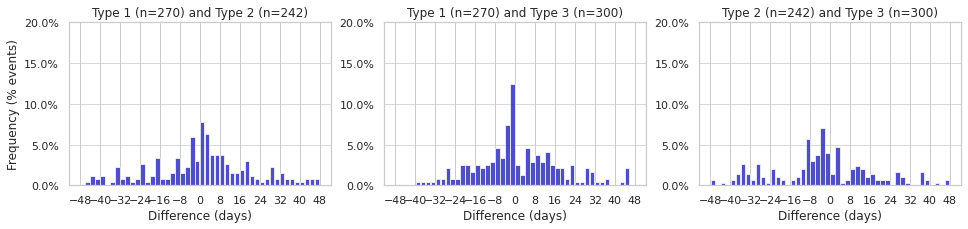

In [32]:
# Create figure
fig = plt.figure(figsize=(16,3))
nrows = 1
ncols = 3
nplots = nrows*ncols
plt_labels = ['Type 1 (n={0}) and Type 2 (n={1})'.format(ns[0], ns[1]),
              'Type 1 (n={0}) and Type 3 (n={1})'.format(ns[0], ns[2]),
              'Type 2 (n={0}) and Type 3 (n={1})'.format(ns[1], ns[2]) ]
ylabels = ['Frequency (% events)', '', '']
for i in np.arange(nplots):
    ax = plt.subplot(nrows, ncols, i+1)
    n, bins, patches = plt.hist(x=data[i], bins=np.arange(-48, 50, 2), color='#0504aa',
                                alpha=0.7, rwidth=0.85, weights=np.ones(len(data[i])) / ns[i])
#     print(len(data[i]))
#     print(ns[i])
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=None))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Difference (days)')
    plt.xticks(np.arange(-48, 50, 8)) 
    plt.ylabel(ylabels[i])
    plt.title(plt_labels[i])
    plt.ylim([0, .20])

# Save figure
filepath = path_to_figs + testname + ssn + '_histogram_perc'+ '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')